# Machine Learning Practical: Coursework 2

**Release date: Wednesday 2nd November 2016**  
**Due date: 16:00 Thursday 24th November 2016**

Instructions for the coursework are [available as a PDF here](http://www.inf.ed.ac.uk/teaching/courses/mlp/2016/coursework_2.pdf).

## Part 1: Does combining L1 and L2 regularisation offer any advantage over using either individually?

### Preparation:
1. Define the L1Penalty and L2Penalty class and difine the L1 and L2 penalties for a parameter and corresponding gradients to implement the call and grad methods respectively.  
   The parameter the penalty term (or gradient) is being evaluated for will be either a one or two-dimensional NumPy array (corresponding to a vector or matrix parameter respectively).  
2. Define the combinging L1Penalty and L2Penalty class and difine the combining L1 and L2 penalties for a parameter and corresponding gradients to implement the call and grad methods respectively. 
3. Set up  
   the data providers  
   a penalty object has been assigned to weights_penalty 
   a seeded random number generator assigned to rng.  
   logger objects needed for training runs.  
   For each regularisation scheme, train the model for 100 epochs with a batch size of 50 and using a gradient descent    with momentum learning rule with learning rate 0.01 and momentum coefficient 0.9.

In [1]:
class L1Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L1 norm.
    """
    
    def __init__(self, coefficient):
        """Create a new L1 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficient > 0., 'Penalty coefficient must be positive.'
        self.coefficient = coefficient
        
    def __call__(self, parameter):
        """Calculate L1 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return self.coefficient * abs(parameter).sum()
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return self.coefficient * np.sign(parameter)
    
    def __repr__(self):
        return 'L1Penalty({0})'.format(self.coefficient)
        

class L2Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L2 norm.
    """

    def __init__(self, coefficient):
        """Create a new L2 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficient > 0., 'Penalty coefficient must be positive.'
        self.coefficient = coefficient
        
    def __call__(self, parameter):
        """Calculate L2 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return 0.5 * self.coefficient * (parameter**2).sum()
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return self.coefficient * parameter
    
    def __repr__(self):
        return 'L2Penalty({0})'.format(self.coefficient)

In [2]:
class combiningL1L2Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their combining L1 and L2 norm.
    """

    def __init__(self, L1_coef, L2_coef):
        """Create a new combining L1 and L2 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert L1_coef > 0., 'Penalty coefficient must be positive.'
        assert L2_coef > 0., 'Penalty coefficient must be positive.'
        self.L1_coef = L1_coef
        self.L2_coef = L2_coef
        
    def __call__(self, parameter):
        """Calculate combining L1 and L2 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return ((self.L1_coef * abs(parameter).sum()) + (0.5 * self.L2_coef * (parameter**2).sum())) * 0.5
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return ((self.L1_coef * np.sign(parameter)) + (self.L2_coef * parameter)) * 0.5
    
    
    def __repr__(self):
        return 'combining L1({0}) L2({1})'.format(self.L1_coef, self.L2_coef)

In [3]:
import numpy as np
from collections import OrderedDict
import logging
from mlp.layers import AffineLayer, ReluLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser

In [4]:
# Seed a random number generator
seed = 24102016 
rng = np.random.RandomState(seed)

num_epochs = 100
stats_interval = 5
batch_size = 50
learning_rate = 0.01
mom_coeff = 0.9
weights_init_gain = 0.5
biases_init = 0.

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)
input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(weights_init_gain, rng)
biases_init = ConstantInit(biases_init)
error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate, mom_coeff)
data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

### Experiment 1:  
1. Train the model and for each regularisation scheme store the run statistics (output of Optimiser.train) and the final values of the first layer weights for each of the trained models.
2. Plot the training set error against epoch number for all different regularisation schemes on the same axis. On a second axis plot the validation set error against epoch number for all the different regularisation schemes. 
3. The cell below defines two functions for visualising the first layer weights of the models trained above. The first plots a histogram of the weight values and the second plots the first layer weights as feature maps, i.e. each row of the first layer weight matrix (corresponding to the weights going from the input MNIST image to a particular first layer output) is visualised as a  28×28  image. In these feature maps white corresponds to negative weights, black to positive weights and grey to weights close to zero.

In [5]:
weights_penalties = [
    None,
    L1Penalty(1e-5),
    L1Penalty(1e-3),
    L2Penalty(1e-4),
    L2Penalty(1e-2),
    combiningL1L2Penalty(1e-3, 1e-2),
    combiningL1L2Penalty(1e-5, 1e-4)
]
run_info = OrderedDict()
models = OrderedDict()
for weights_penalty in weights_penalties:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()
    print('Regularisation: {0}'.format(weights_penalty))
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, 
                    biases_init, weights_penalty)
    ])
    optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)
    run_info[weights_penalty] = optimiser.train(num_epochs, stats_interval)
    models[weights_penalty] = model

Regularisation: None


Epoch 5: 2.04s to complete
  error(train)=6.34e-02, acc(train)=9.82e-01, error(valid)=9.67e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 10: 1.91s to complete
  error(train)=2.36e-02, acc(train)=9.94e-01, error(valid)=8.34e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 15: 1.94s to complete
  error(train)=8.49e-03, acc(train)=9.98e-01, error(valid)=8.34e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 20: 2.01s to complete
  error(train)=3.42e-03, acc(train)=1.00e+00, error(valid)=9.58e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 25: 2.03s to complete
  error(train)=1.42e-03, acc(train)=1.00e+00, error(valid)=9.48e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 30: 2.28s to complete
  error(train)=9.06e-04, acc(train)=1.00e+00, error(valid)=1.01e-01, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 35: 1.89s to complete
  error(train)=6.40e-04, acc(train)=1.00e+00, error(valid)=1.04e-01, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 4

Regularisation: L1Penalty(1e-05)


Epoch 5: 2.82s to complete
  error(train)=6.46e-02, acc(train)=9.82e-01, error(valid)=9.39e-02, acc(valid)=9.73e-01, params_penalty=2.89e-02
Epoch 10: 2.74s to complete
  error(train)=2.68e-02, acc(train)=9.93e-01, error(valid)=8.04e-02, acc(valid)=9.78e-01, params_penalty=3.03e-02
Epoch 15: 2.63s to complete
  error(train)=1.42e-02, acc(train)=9.97e-01, error(valid)=8.12e-02, acc(valid)=9.78e-01, params_penalty=3.06e-02
Epoch 20: 2.56s to complete
  error(train)=6.73e-03, acc(train)=9.99e-01, error(valid)=8.81e-02, acc(valid)=9.77e-01, params_penalty=2.99e-02
Epoch 25: 3.07s to complete
  error(train)=3.55e-03, acc(train)=1.00e+00, error(valid)=8.79e-02, acc(valid)=9.78e-01, params_penalty=2.85e-02
Epoch 30: 3.91s to complete
  error(train)=2.77e-03, acc(train)=1.00e+00, error(valid)=9.02e-02, acc(valid)=9.78e-01, params_penalty=2.69e-02
Epoch 35: 2.75s to complete
  error(train)=2.19e-03, acc(train)=1.00e+00, error(valid)=8.69e-02, acc(valid)=9.79e-01, params_penalty=2.56e-02
Epoch 4

Regularisation: L1Penalty(0.001)


Epoch 5: 3.11s to complete
  error(train)=2.53e-01, acc(train)=9.31e-01, error(valid)=2.40e-01, acc(valid)=9.35e-01, params_penalty=3.12e-01
Epoch 10: 3.24s to complete
  error(train)=2.22e-01, acc(train)=9.35e-01, error(valid)=2.15e-01, acc(valid)=9.37e-01, params_penalty=2.76e-01
Epoch 15: 2.73s to complete
  error(train)=2.27e-01, acc(train)=9.34e-01, error(valid)=2.15e-01, acc(valid)=9.37e-01, params_penalty=2.60e-01
Epoch 20: 2.84s to complete
  error(train)=2.80e-01, acc(train)=9.14e-01, error(valid)=2.62e-01, acc(valid)=9.19e-01, params_penalty=2.63e-01
Epoch 25: 2.60s to complete
  error(train)=2.37e-01, acc(train)=9.28e-01, error(valid)=2.33e-01, acc(valid)=9.29e-01, params_penalty=2.58e-01
Epoch 30: 3.51s to complete
  error(train)=2.25e-01, acc(train)=9.34e-01, error(valid)=2.15e-01, acc(valid)=9.39e-01, params_penalty=2.54e-01
Epoch 35: 2.56s to complete
  error(train)=2.04e-01, acc(train)=9.38e-01, error(valid)=1.96e-01, acc(valid)=9.44e-01, params_penalty=2.56e-01
Epoch 4

Regularisation: L2Penalty(0.0001)


Epoch 5: 2.12s to complete
  error(train)=6.49e-02, acc(train)=9.81e-01, error(valid)=9.48e-02, acc(valid)=9.72e-01, params_penalty=1.19e-02
Epoch 10: 2.20s to complete
  error(train)=2.65e-02, acc(train)=9.93e-01, error(valid)=8.14e-02, acc(valid)=9.78e-01, params_penalty=1.54e-02
Epoch 15: 2.14s to complete
  error(train)=1.41e-02, acc(train)=9.97e-01, error(valid)=8.20e-02, acc(valid)=9.78e-01, params_penalty=1.75e-02
Epoch 20: 2.31s to complete
  error(train)=6.66e-03, acc(train)=9.99e-01, error(valid)=8.53e-02, acc(valid)=9.78e-01, params_penalty=1.85e-02
Epoch 25: 2.22s to complete
  error(train)=3.56e-03, acc(train)=1.00e+00, error(valid)=8.34e-02, acc(valid)=9.79e-01, params_penalty=1.87e-02
Epoch 30: 2.13s to complete
  error(train)=2.80e-03, acc(train)=1.00e+00, error(valid)=8.27e-02, acc(valid)=9.79e-01, params_penalty=1.85e-02
Epoch 35: 2.11s to complete
  error(train)=2.53e-03, acc(train)=1.00e+00, error(valid)=8.15e-02, acc(valid)=9.80e-01, params_penalty=1.82e-02
Epoch 4

Regularisation: L2Penalty(0.01)


Epoch 5: 2.07s to complete
  error(train)=2.36e-01, acc(train)=9.41e-01, error(valid)=2.21e-01, acc(valid)=9.45e-01, params_penalty=2.90e-01
Epoch 10: 2.07s to complete
  error(train)=2.13e-01, acc(train)=9.45e-01, error(valid)=1.99e-01, acc(valid)=9.52e-01, params_penalty=2.95e-01
Epoch 15: 2.46s to complete
  error(train)=2.22e-01, acc(train)=9.44e-01, error(valid)=2.08e-01, acc(valid)=9.48e-01, params_penalty=2.96e-01
Epoch 20: 2.12s to complete
  error(train)=2.15e-01, acc(train)=9.46e-01, error(valid)=2.03e-01, acc(valid)=9.49e-01, params_penalty=2.98e-01
Epoch 25: 2.23s to complete
  error(train)=2.14e-01, acc(train)=9.47e-01, error(valid)=2.03e-01, acc(valid)=9.50e-01, params_penalty=2.99e-01
Epoch 30: 2.15s to complete
  error(train)=2.02e-01, acc(train)=9.51e-01, error(valid)=1.91e-01, acc(valid)=9.55e-01, params_penalty=2.99e-01
Epoch 35: 2.54s to complete
  error(train)=2.11e-01, acc(train)=9.46e-01, error(valid)=2.01e-01, acc(valid)=9.50e-01, params_penalty=2.97e-01
Epoch 4

Regularisation: combining L1(0.001) L2(0.01)


Epoch 5: 3.29s to complete
  error(train)=2.61e-01, acc(train)=9.31e-01, error(valid)=2.42e-01, acc(valid)=9.38e-01, params_penalty=3.43e-01
Epoch 10: 3.04s to complete
  error(train)=2.35e-01, acc(train)=9.36e-01, error(valid)=2.18e-01, acc(valid)=9.41e-01, params_penalty=3.18e-01
Epoch 15: 3.01s to complete
  error(train)=2.37e-01, acc(train)=9.37e-01, error(valid)=2.17e-01, acc(valid)=9.42e-01, params_penalty=3.13e-01
Epoch 20: 2.98s to complete
  error(train)=2.54e-01, acc(train)=9.30e-01, error(valid)=2.34e-01, acc(valid)=9.37e-01, params_penalty=3.13e-01
Epoch 25: 3.10s to complete
  error(train)=2.38e-01, acc(train)=9.36e-01, error(valid)=2.24e-01, acc(valid)=9.39e-01, params_penalty=3.09e-01
Epoch 30: 2.99s to complete
  error(train)=2.25e-01, acc(train)=9.42e-01, error(valid)=2.11e-01, acc(valid)=9.49e-01, params_penalty=3.10e-01
Epoch 35: 2.96s to complete
  error(train)=2.32e-01, acc(train)=9.36e-01, error(valid)=2.14e-01, acc(valid)=9.44e-01, params_penalty=3.08e-01
Epoch 4

Regularisation: combining L1(1e-05) L2(0.0001)


Epoch 5: 3.58s to complete
  error(train)=6.42e-02, acc(train)=9.82e-01, error(valid)=9.34e-02, acc(valid)=9.73e-01, params_penalty=2.08e-02
Epoch 10: 2.99s to complete
  error(train)=2.73e-02, acc(train)=9.92e-01, error(valid)=7.99e-02, acc(valid)=9.77e-01, params_penalty=2.37e-02
Epoch 15: 3.33s to complete
  error(train)=1.57e-02, acc(train)=9.96e-01, error(valid)=8.31e-02, acc(valid)=9.77e-01, params_penalty=2.52e-02
Epoch 20: 2.95s to complete
  error(train)=6.77e-03, acc(train)=9.99e-01, error(valid)=8.58e-02, acc(valid)=9.78e-01, params_penalty=2.56e-02
Epoch 25: 2.94s to complete
  error(train)=3.55e-03, acc(train)=1.00e+00, error(valid)=8.22e-02, acc(valid)=9.79e-01, params_penalty=2.52e-02
Epoch 30: 2.89s to complete
  error(train)=2.68e-03, acc(train)=1.00e+00, error(valid)=8.22e-02, acc(valid)=9.79e-01, params_penalty=2.45e-02
Epoch 35: 2.93s to complete
  error(train)=2.50e-03, acc(train)=1.00e+00, error(valid)=8.20e-02, acc(valid)=9.79e-01, params_penalty=2.37e-02
Epoch 4

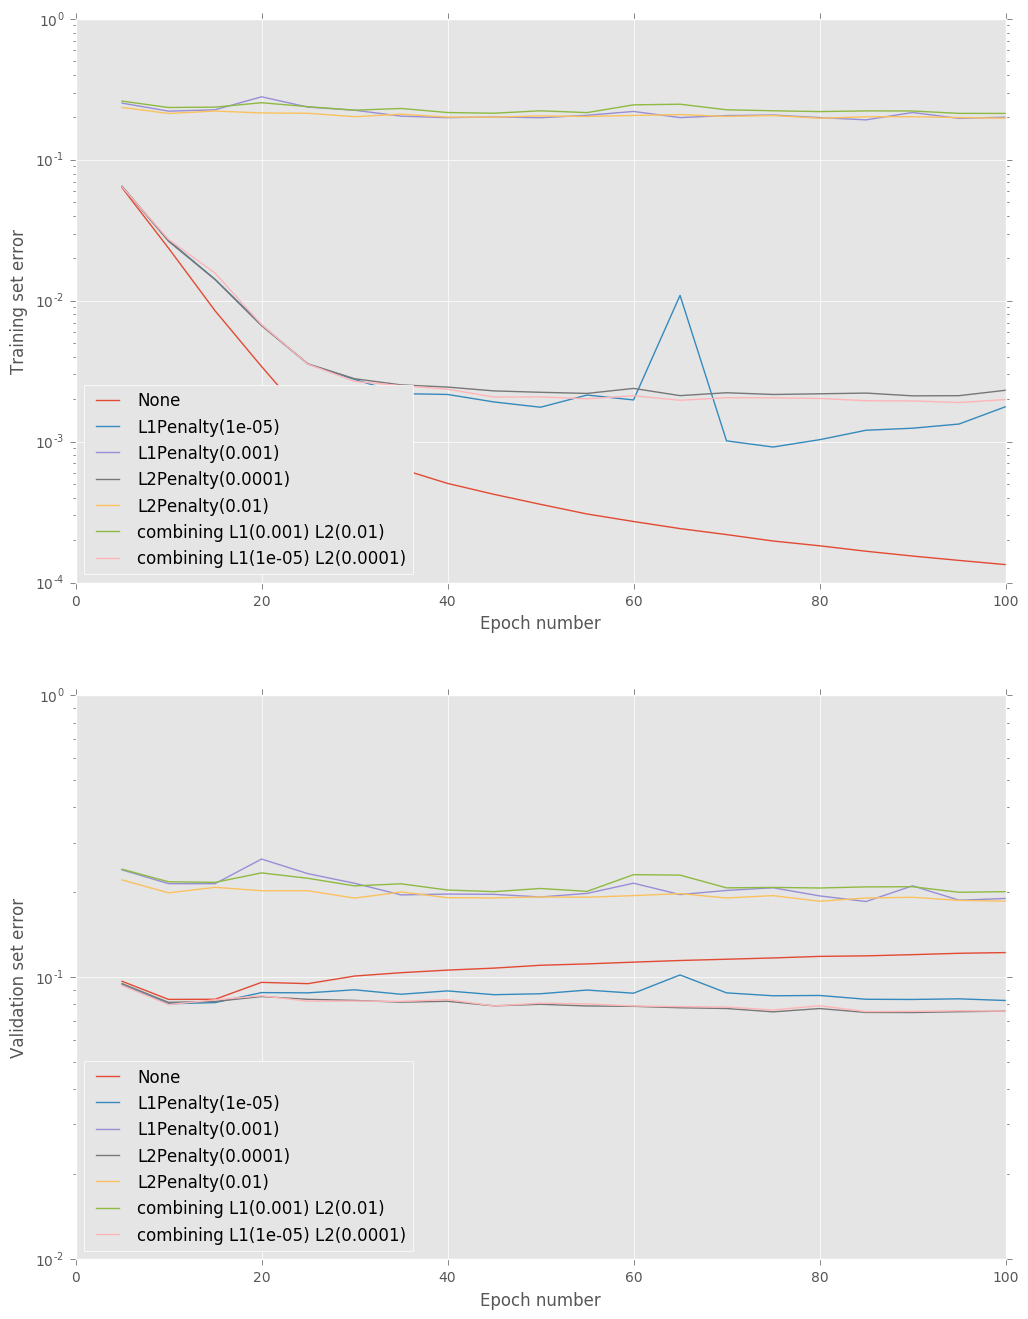

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
for weight_penalty, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(weight_penalty))
ax1.legend(loc='lower left')
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc='lower left')
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

In [7]:
def plot_param_histogram(param, fig_size=(6, 3), interval=[-1.5, 1.5]):
    """Plots a normalised histogram of an array of parameter values."""
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111)
    ax.hist(param.flatten(), 50, interval, normed=True)
    ax.set_xlabel('Parameter value')
    ax.set_ylabel('Normalised frequency density')
    return fig, ax

def visualise_first_layer_weights(weights, fig_size=(5, 5)):
    """Plots a grid of first layer weights as feature maps."""
    fig = plt.figure(figsize=fig_size)
    num_feature_maps = weights.shape[0]
    grid_size = int(num_feature_maps**0.5)
    max_abs = np.abs(model.params[0]).max()
    tiled = -np.ones((30 * grid_size, 
                      30 * num_feature_maps // grid_size)) * max_abs
    for i, fm in enumerate(model.params[0]):
        r, c = i % grid_size, i // grid_size
        tiled[1 + r * 30:(r + 1) * 30 - 1, 
              1 + c * 30:(c + 1) * 30 - 1] = fm.reshape((28, 28))
    ax = fig.add_subplot(111)
    max_abs = np.abs(tiled).max()
    ax.imshow(tiled, cmap='Greys', vmin=-max_abs, vmax=max_abs)
    ax.axis('off')
    fig.tight_layout()
    plt.show()
    return fig, ax

Regularisation: None


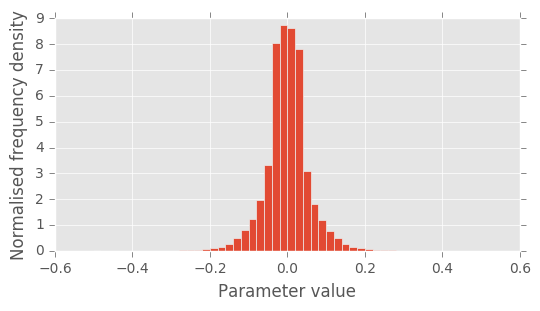

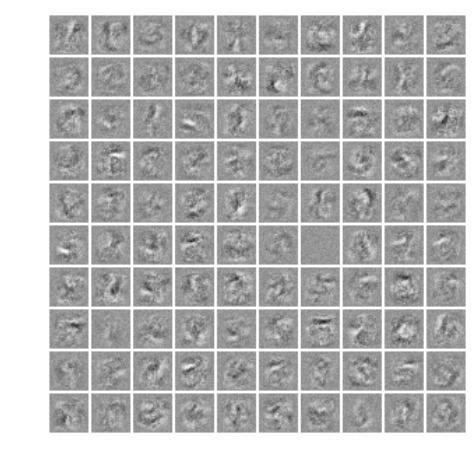

Regularisation: L1Penalty(1e-05)


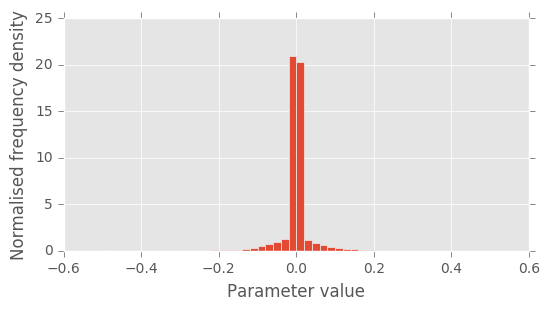

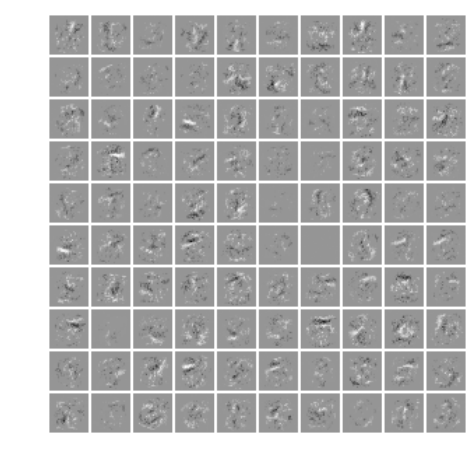

Regularisation: L1Penalty(0.001)


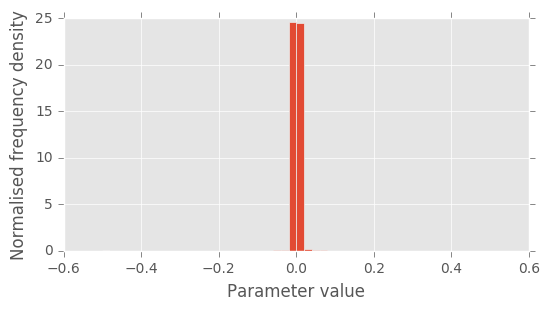

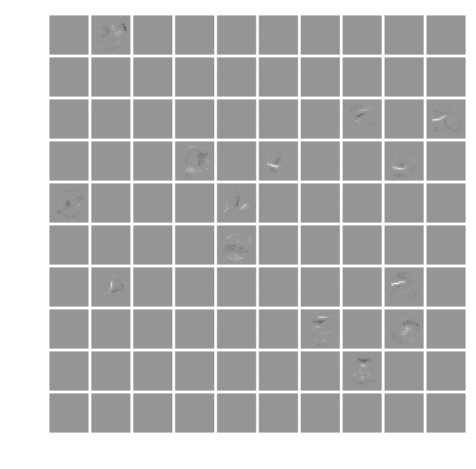

Regularisation: L2Penalty(0.0001)


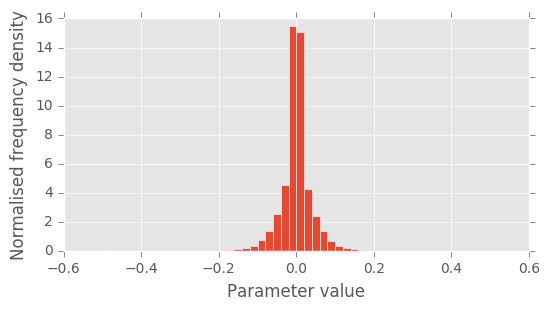

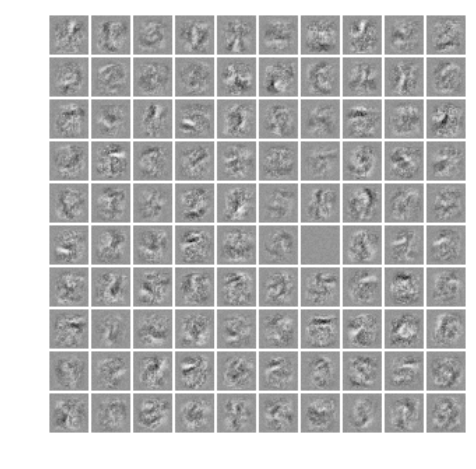

Regularisation: L2Penalty(0.01)


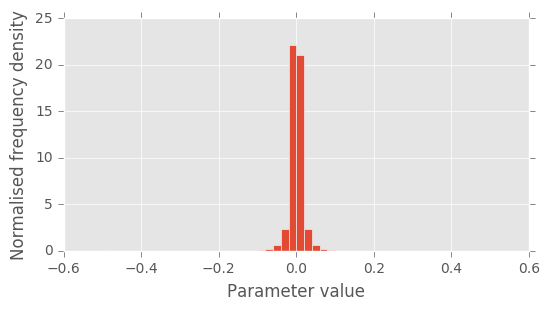

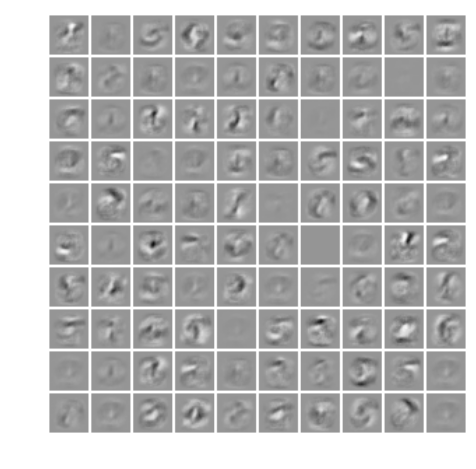

Regularisation: combining L1(0.001) L2(0.01)


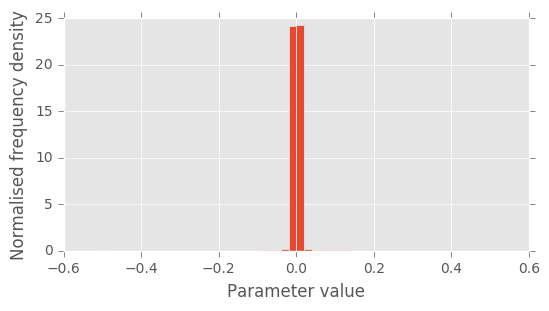

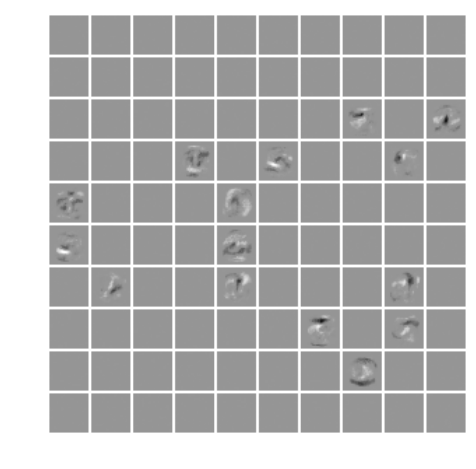

Regularisation: combining L1(1e-05) L2(0.0001)


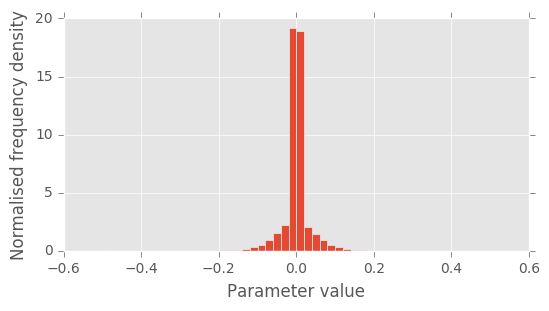

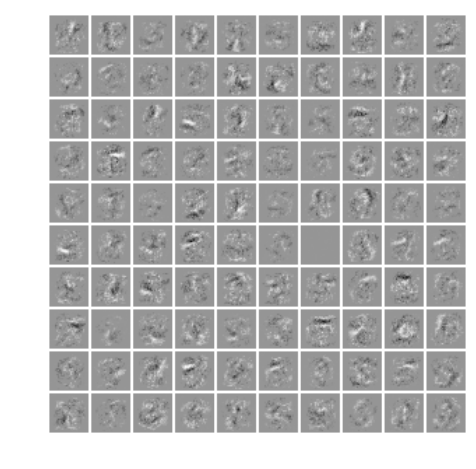

In [8]:
for weight_penalty, model in models.items():
    print('Regularisation: {0}'.format(weight_penalty))
    _ = plot_param_histogram(model.params[0], interval=[-0.5, 0.5])
    _ = visualise_first_layer_weights(model.params[0])

## Part 2: Data Augmentation

### Preparation:
1. Define the function to apply rotation, shift, zoom out and add noise for the handwritten image inputs in the MNIST dataset
2. Define the function to to visualise the images in a batch before and after application of the those transformations. 
3. test implementation.

In [9]:
from scipy.ndimage.interpolation import rotate
from scipy.ndimage.interpolation import shift
from scipy.ndimage.interpolation import zoom
import numpy as np

def random_rotation(inputs, rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(-1., 1., size=indices.shape[0]) * 30.
    for i, j in enumerate(indices):
        new_ims[j] = rotate(orig_ims[j], angles[i], order=1, reshape=False)
    return new_ims.reshape((-1, 784))

def random_shift(inputs, rng):
    """Randomly shift a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images shifted along the axes. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    axes = rng.uniform(-1., 1., size=indices.shape[0]) * 5.
    for i, j in enumerate(indices):
        new_ims[j] = shift(orig_ims[j], axes[i], order=1)
    return new_ims.reshape((-1, 784))

def random_zoomout(inputs, rng):
    """Randomly shift a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images shifted along the axes. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    axes = rng.uniform(0.5, 1., size=indices.shape[0])
    for i, j in enumerate(indices):
        temp = zoom(orig_ims[j], axes[i], order=1)
        temp1 = np.zeros((28, 28))
        temp1[(28 - temp.shape[0]) // 2 : (28 - temp.shape[0]) // 2 + temp.shape[0] 
                , (28 - temp.shape[1]) // 2 : (28 - temp.shape[1]) // 2 + temp.shape[1]] = temp 
        new_ims[j] = temp1
    return new_ims.reshape((-1, 784))

def random_noise(inputs, rng):
    """Randomly add noise in a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images added noise. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    noise_p = rng.normal(1., 1., size=(indices.shape[0],28,28))
    for i, j in enumerate(indices):
        new_ims[j] = orig_ims[j] * noise_p[i]
    return new_ims.reshape((-1, 784))

In [10]:
def show_batch_of_images(img_batch, fig_size=(3, 3)):
    fig = plt.figure(figsize=fig_size)
    batch_size, im_height, im_width = img_batch.shape
    # calculate no. columns per grid row to give square grid
    grid_size = int(batch_size**0.5)
    # intialise empty array to tile image grid into
    tiled = np.empty((im_height * grid_size, 
                      im_width * batch_size // grid_size))
    # iterate over images in batch + indexes within batch
    for i, img in enumerate(img_batch):
        # calculate grid row and column indices
        r, c = i % grid_size, i // grid_size
        tiled[r * im_height:(r + 1) * im_height, 
              c * im_height:(c + 1) * im_height] = img
    ax = fig.add_subplot(111)
    ax.imshow(tiled, cmap='Greys') #, vmin=0., vmax=1.)
    ax.axis('off')
    fig.tight_layout()
    plt.show()
    return fig, ax

Origin Input


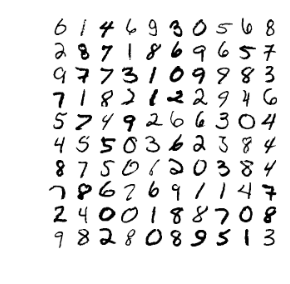

New input by rotation


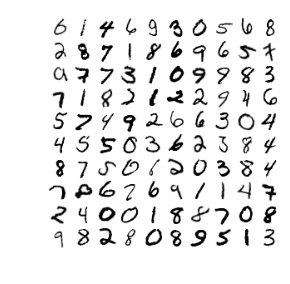

New input by shifting


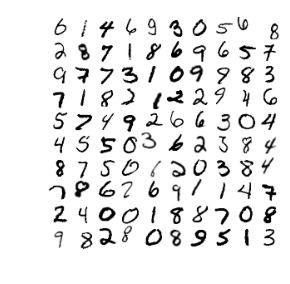

New input by zooming out


/Users/Meteor/anaconda/envs/mlp/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


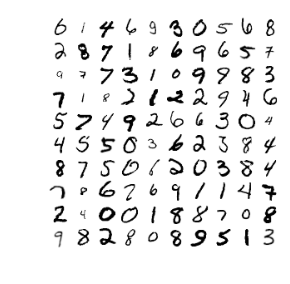

New input by adding noise


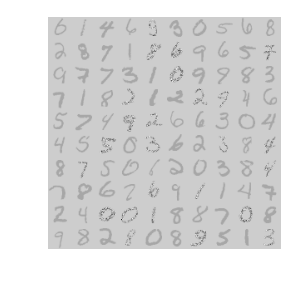

In [11]:
test_data = MNISTDataProvider('test', 100, rng=rng)
print("Origin Input")
inputs, targets = test_data.next()
_ = show_batch_of_images(inputs.reshape((-1, 28, 28)))

print("New input by rotation")
rotation_inputs = random_rotation(inputs, rng)
_ = show_batch_of_images(rotation_inputs.reshape((-1, 28, 28)))

print("New input by shifting")
shifting_inputs = random_shift(inputs, rng)
_ = show_batch_of_images(shifting_inputs.reshape((-1, 28, 28)))

print("New input by zooming out")
zoom_out_inputs = random_zoomout(inputs, rng)
_ = show_batch_of_images(zoom_out_inputs.reshape((-1, 28, 28)))

print("New input by adding noise")
noise_inputs = random_noise(inputs, rng)
_ = show_batch_of_images(noise_inputs.reshape((-1, 28, 28)))

### Experiment 2:  
1. Randomly augment the data on the fly as we iterate through the data provider in each epoch. In addition to the arguments of the original MNISTDataProvider. Init method, this additional takes a transformer argument, which should be a function which takes as arguments an inputs batch array and a random number generator object, and returns an array corresponding to a random transformation of the inputs. 
2. Train a model with the same architecture as in part 1 and with no L1 / L2 regularisation using a training data provider which randomly augments the training images using random_rotation, random_shift, random_noise transformer function. 
3. Plot the training and validation set errors over the training epochs.

In [12]:
from mlp.data_providers import AugmentedMNISTDataProvider

aug_train_data1 = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_rotation)
aug_train_data2 = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_shift)
aug_train_data3 = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_zoomout)
aug_train_data4 = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_noise)
aug_train_data = [aug_train_data1, aug_train_data2, aug_train_data3, aug_train_data4]

In [13]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5
aug_info = []

for a in aug_train_data:
    rng.seed(seed)
    a.reset()
    valid_data.reset()
    a.batch_size = batch_size 
    valid_data.batch_size = batch_size

    weights_init = GlorotUniformInit(0.5, rng=rng)
    biases_init = ConstantInit(0.)

    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])

    error = CrossEntropySoftmaxError()
    learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
    optimiser = Optimiser(
        model, error, learning_rule, a, valid_data, data_monitors)

    aug_stats, aug_keys, aug_run_time = optimiser.train(
        num_epochs=num_epochs, stats_interval=stats_interval)
    aug_info.append([aug_stats, aug_keys, aug_run_time])

Epoch 5: 3.32s to complete
  error(train)=1.45e-01, acc(train)=9.57e-01, error(valid)=1.23e-01, acc(valid)=9.65e-01, params_penalty=0.00e+00
Epoch 10: 3.26s to complete
  error(train)=8.53e-02, acc(train)=9.74e-01, error(valid)=8.48e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 15: 3.28s to complete
  error(train)=6.26e-02, acc(train)=9.81e-01, error(valid)=7.69e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 20: 3.24s to complete
  error(train)=5.26e-02, acc(train)=9.85e-01, error(valid)=7.79e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 25: 3.28s to complete
  error(train)=4.33e-02, acc(train)=9.88e-01, error(valid)=7.29e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 30: 3.31s to complete
  error(train)=3.72e-02, acc(train)=9.89e-01, error(valid)=7.23e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 35: 3.24s to complete
  error(train)=3.56e-02, acc(train)=9.90e-01, error(valid)=7.50e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 4

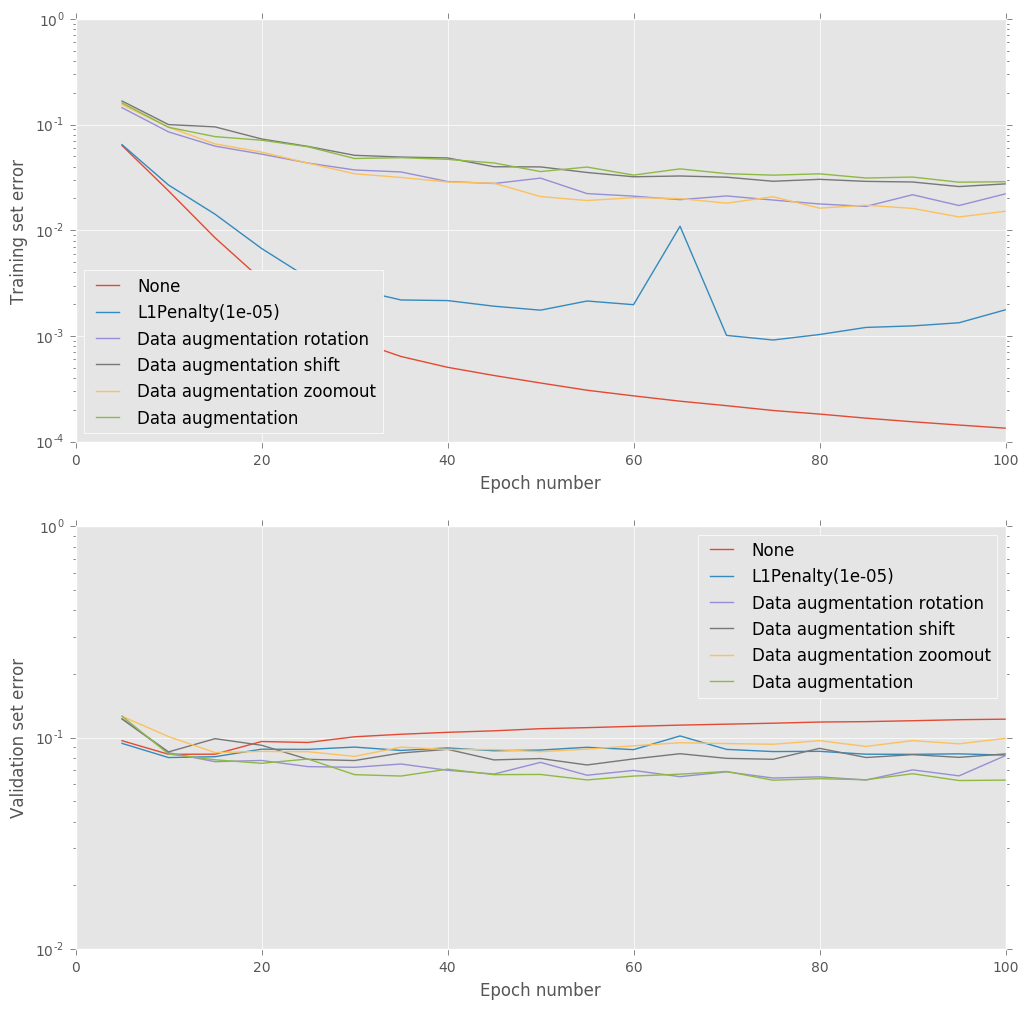

In [16]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
count = 0
for weight_penalty, run in run_info.items():
    if(count < 2):
        stats, keys, run_time = run
        ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                 stats[1:, keys['error(train)']], label=str(weight_penalty))
        ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                 stats[1:, keys['error(valid)']], label=str(weight_penalty))
        count += 1
ax1.plot(np.arange(1, aug_stats.shape[0]) * stats_interval, 
         aug_info[0][0][1:, aug_info[0][1]['error(train)']], label='Data augmentation rotation')
ax2.plot(np.arange(1, aug_stats.shape[0]) * stats_interval, 
         aug_info[0][0][1:, aug_info[0][1]['error(valid)']], label='Data augmentation rotation')
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

ax1.plot(np.arange(1, aug_stats.shape[0]) * stats_interval, 
         aug_info[1][0][1:, aug_info[1][1]['error(train)']], label='Data augmentation shift')
ax2.plot(np.arange(1, aug_stats.shape[0]) * stats_interval, 
         aug_info[1][0][1:, aug_info[1][1]['error(valid)']], label='Data augmentation shift')
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

ax1.plot(np.arange(1, aug_stats.shape[0]) * stats_interval, 
         aug_info[2][0][1:, aug_info[2][1]['error(train)']], label='Data augmentation zoomout')
ax2.plot(np.arange(1, aug_stats.shape[0]) * stats_interval, 
         aug_info[2][0][1:, aug_info[2][1]['error(valid)']], label='Data augmentation zoomout')
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

ax1.plot(np.arange(1, aug_stats.shape[0]) * stats_interval, 
         aug_info[3][0][1:, aug_info[3][1]['error(train)']], label='Data augmentation')
ax2.plot(np.arange(1, aug_stats.shape[0]) * stats_interval, 
         aug_info[3][0][1:, aug_info[3][1]['error(valid)']], label='Data augmentation')
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

## Part 3: Models with Convolutional Layers

### Preparation:
1. Define the function to apply rotation, shift, zoom and affine transformation for the handwritten image inputs in the MNIST dataset
2. Define the function to to visualise the images in a batch before and after application of the random rotation transformation. 

### Experiment 3:  
**Display** how the different **learning rate** affects the evolution of the training.

### Experiment 2.4:  
**Display** how the different **coefficient tends speed** affects the evolution of the training.

## Part 3: Adaptive learning rules

### Experiment 3.1:  
**Compare** the performance of **AdagradLearningRule** and **RMSpropLearningRule** when training the standard model on the MINIST digit classification task